<a href="https://colab.research.google.com/github/chatwipa-sur/SRCC_detection/blob/main/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

In [43]:
# !pip install pascal-voc-writer lxml

In [44]:
# Library for directory actions (file handling, path operations)
import os
import json
import random
import shutil

# Library for XML parsing (used to read annotation files)
import xml.etree.ElementTree as ET

# Library for collecting data in dictionary-like objects
from collections import defaultdict

# Library for image processing and visualization
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Library for data manipulation and annotation parsing
import pandas as pd

# PyTorch library
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F
from torch.utils.data import random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Library for numerical computations
import numpy as np

In [45]:
# Mount the drive with google colab notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Load dataset

### 1.1 Main code

In [46]:
# Make heatmaps using the utility functions from the centernet repo
# Draw a Gaussian centered at a point on a heatmap
def draw_msra_gaussian(heatmap, center, sigma=10):
  # Total size (radius) of the Gaussian region
  tmp_size = sigma * 6

  # Round the x and y center to nearest int
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)

  # Get heatmap dimensions
  w, h = heatmap.shape[0], heatmap.shape[1]

  # Upper-left and bottom-right corners of the Gaussian patch
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]

  # If Gaussian patch is completely outside the heatmap, return
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap

  # Create a 2D Gaussian
  size = 2 * tmp_size + 1 # Size of the Gaussian patch
  x = np.arange(0, size, 1, np.float32) # x coordinates
  y = x[:, np.newaxis] # y coordinates
  x0 = y0 = size // 2 # Center of the Gaussian
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2)) # 2D Gaussian formula

  # Compute valid bounds for placing the Gaussian patch on the heatmap
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)

  # Place the Gaussian on the heatmap using max to retain highest intensity
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])

  return heatmap

# Draw a dense regression value map around a center point
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  # Size of the square region
  diameter = 2 * radius + 1
  # Create Gaussian mask
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

  # Convert value to float32 and reshape to [dim, 1, 1]
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)
  dim = value.shape[0]

  # Create a repeated value map of shape [dim, H, W]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value

  # If it's an offset, adjust the values using distance from center
  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)

  # Center coordinates
  x, y = int(center[0]), int(center[1])

  # Heatmap dimensions
  height, width = heatmap.shape[0:2]

  # Compute boundaries (clipping at image edges)
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  # Crop regions from heatmap, regmap, Gaussian, and value maps
  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]

  # Only update if region is valid (non-zero size)
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug

    # Create a mask where Gaussian is stronger than existing heatmap
    idx = (masked_gaussian >= masked_heatmap).reshape(1, masked_gaussian.shape[0],
                                                      masked_gaussian.shape[1])

    # Update regmap only where mask is True (using Gaussian gate)
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg

  # Write updated region back to original regmap
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap

  return regmap

def gaussian2D(shape, sigma=1):
    # Get center and coordinate grid
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    # Apply 2D Gaussian function
    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))

    # Remove near-zero values for stability
    h[h < np.finfo(h.dtype).eps * h.max()] = 0

    return h

def make_hm_regr(target, input_size=512, MODEL_SCALE=4):

    IN_SCALE = 1
    # make output heatmap for single class
    hm = np.zeros([input_size//MODEL_SCALE, input_size//MODEL_SCALE], dtype=np.float32)
    # make regr heatmap
    regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE], dtype=np.float32)

    if target.empty:
        return hm, regr

    center = np.array([target["x"] + target["w"]//2, target["y"] + target["h"]//2,
                       target["w"], target["h"]]).T

    # make a center point
    # try gaussian points.
    for c in center:
        hm = draw_msra_gaussian(hm, [int(c[0])//MODEL_SCALE//IN_SCALE,
                                     int(c[1])//MODEL_SCALE//IN_SCALE],
                                sigma=np.clip(c[2]*c[3]//2000, 5, 10))

    # convert targets to its center.
    regrs = center[:, 2:]/input_size/IN_SCALE

    # plot regr values to mask
    for r, c in zip(regrs, center):
        for i in range(-2, 3):
            for j in range(-2, 3):
                try:
                    regr[:, int(c[0])//MODEL_SCALE//IN_SCALE+i,
                         int(c[1])//MODEL_SCALE//IN_SCALE+j] = r
                except:
                    pass
    regr[0] = regr[0].T; regr[1] = regr[1].T;

    return hm, regr

def pred2box(hm, regr, thresh=0.99, MODEL_SCALE=4, input_size=512):
    pred = hm > thresh
    pred_center = np.where(pred)
    pred_r = regr[:, pred].T  # Shape: [N, 2] for w, h
    boxes = []
    scores = hm[pred]

    for i, b in enumerate(pred_r):
        cx = pred_center[1][i] * MODEL_SCALE
        cy = pred_center[0][i] * MODEL_SCALE

        w = b[0] * input_size
        h = b[1] * input_size

        x1 = cx - w /2
        y1 = cy - h /2

        arr = np.clip([x1, y1, w, h], 0, input_size)
        boxes.append(arr)

    return np.asarray(boxes), scores


# Assuming `image` is a torch.Tensor of shape (3, H, W)
def unnormalize_tensor(image):
  mean = [0.485, 0.456, 0.406]
  std  = [0.229, 0.224, 0.225]
  for t, m, s in zip(image, mean, std):
    t.mul_(s).add_(m)
  return image

In [54]:
class SignetRingCellPatchCenterNetDataset(Dataset):
  def __init__(self, image_dir, annotation_dir, patch_size=512, transform=None):
    # Initialize parameters
    self.patch_size = patch_size
    self.stride = patch_size//2  # 50% overlap for 512x512 patches
    self.transform = transform
    self.image_information = []

    # Loop over positive and negative folders
    for class_type in ['positive', 'negative']:
    # for class_type in ['positive']:
      full_image_dir = os.path.join(image_dir, class_type)
      full_anno_dir = os.path.join(annotation_dir, class_type)

      # Iterate over image files in the folder
      for fname in os.listdir(full_image_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
          # Collect image path
          image_path = os.path.join(full_image_dir, fname)

          # Collect annotation path
          if class_type == "positive":
            anno_filename = fname.replace('.png', '.xml').replace('.jpg', '.xml').replace('.jpeg', '.xml')
            anno_path = os.path.join(full_anno_dir, anno_filename)
          else:
            anno_path = None  # no annotation for negatives

          # Get the size of image
          image = cv2.imread(image_path)
          height, width = image.shape[:2]

          # Generate sliding window patches
          for top in range(0, height - self.patch_size + 1, self.stride):
            for left in range(0, width - self.patch_size + 1, self.stride):
              self.image_information.append({
                  'image_path': image_path,
                  'annotation_path': anno_path,
                  'crop_box': (left, top, left + self.patch_size, top + self.patch_size),
                  'flag': 1 if class_type == 'positive' else 0
              })

  def __len__(self):
    return len(self.image_information) # Total number of patches

  def __getitem__(self, idx):
    # Get image for this index
    image_info = self.image_information[idx]
    image = cv2.imread(image_info['image_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crop patch using numpy slicing: [top:bottom, left:right]
    left, top, right, bottom = image_info['crop_box']
    image_patch = image[top:bottom, left:right]

    # Get type of image
    flag = image_info['flag']

    # Load and process annotations
    boxes_list = []
    category_ids = []
    if image_info['annotation_path'] is not None:
        tree = ET.parse(image_info['annotation_path'])
        root = tree.getroot()

        crop_xmin, crop_ymin, crop_xmax, crop_ymax = image_info['crop_box']
        for obj in root.findall('object'):
            name = obj.find('name').text
            if name == 'ring_cell_cancer':
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)

                if (xmin >= crop_xmin and xmax <= crop_xmax) and (ymin >= crop_ymin and ymax <= crop_ymax):
                    new_xmin = xmin - crop_xmin
                    new_ymin = ymin - crop_ymin
                    new_xmax = xmax - crop_xmin
                    new_ymax = ymax - crop_ymin
                    boxes_list.append((new_xmin, new_ymin,
                                       new_xmax - new_xmin,
                                       new_ymax - new_ymin))
                    category_ids.append(1)  # ring_cell_cancer

    # Apply transform (if any)
    if self.transform and len(boxes_list) > 0:
        transformed = self.transform(
            image=image_patch,
            bboxes=boxes_list,
            category_ids=category_ids
        )
        image_patch = transformed['image']
        boxes_list = transformed['bboxes']
    elif self.transform:
        transformed = self.transform(image=image_patch, bboxes=[], category_ids=[])
        image_patch = transformed['image']

    # Generate heatmap + regression map
    if len(boxes_list) == 0:
        hm = np.zeros([self.patch_size // 4, self.patch_size // 4], dtype=np.float32)
        regr = np.zeros([2, self.patch_size // 4, self.patch_size // 4], dtype=np.float32)
    else:
        target = pd.DataFrame(boxes_list, columns=['x', 'y', 'w', 'h'])
        hm, regr = make_hm_regr(target)

    return image_patch, hm, regr, boxes_list, flag

### 1.2 Augmentation transform function

In [65]:
# Transform function
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),  # converts image and bounding boxes to torch.Tensor
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))


# Transform function
val_test_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

### 1.3 Dataset loader

In [66]:
# Path of dataset
image_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset/train"
annotation_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset/annotations/train"

# Load dataset and patching
dataset = SignetRingCellPatchCenterNetDataset(image_dir, annotation_dir, transform=train_transform)
image_patch, hm, regr, boxes_list, _ = dataset[0]

print(image_patch.shape)

torch.Size([3, 512, 512])


torch.Size([3, 512, 512])


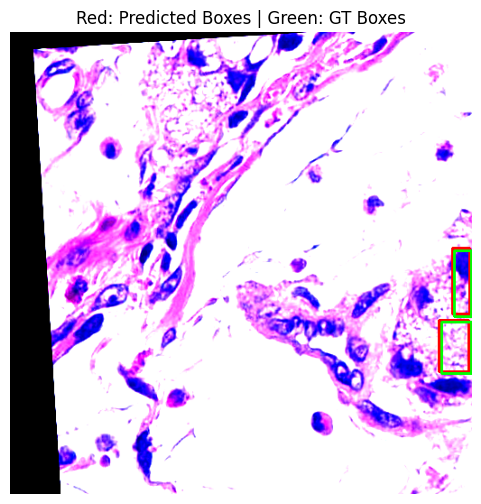

In [67]:
# Get image
image, hm, regr, gt_boxes,_ = dataset[10]
print(image.shape)

# Get predicted boxes
pred_boxes, _ = pred2box(hm, regr)

# Convert image to numpy
image = image.clone().permute(1, 2, 0).numpy()

# Make a copy for drawing
image_copy = image.copy()

# Draw predicted boxes (red)
for box in pred_boxes:
    x, y, w, h = map(int, box)
    cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Draw GT boxes (green)
for box in gt_boxes:
    x1, y1, w, h = map(int, box)
    cv2.rectangle(image_copy, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)

# Display
plt.figure(figsize=(6, 6))
plt.imshow(image_copy)
plt.title("Red: Predicted Boxes | Green: GT Boxes")
plt.axis("off")
plt.show()

## 2. DataLoader

In [70]:
# Paths
dataset_base_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset"

# Train and Validation dataset
train_dataset = SignetRingCellPatchCenterNetDataset(
    image_dir=os.path.join(dataset_base_dir, "train"),
    annotation_dir=os.path.join(dataset_base_dir, "annotations/train"),
    transform=train_transform
)

val_dataset = SignetRingCellPatchCenterNetDataset(
    image_dir=os.path.join(dataset_base_dir, "val"),
    annotation_dir=os.path.join(dataset_base_dir, "annotations/val"),
    transform=val_test_transform
)

# Test dataset
test_dataset = SignetRingCellPatchCenterNetDataset(
    image_dir=os.path.join(dataset_base_dir, "test"),
    annotation_dir=os.path.join(dataset_base_dir, "annotations/test"),
    transform=val_test_transform
)

# Define a custom collate function to handle the variable-length gt_boxes
def custom_collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    hms = torch.stack([torch.from_numpy(item[1]).float() for item in batch])
    regrs = torch.stack([torch.from_numpy(item[2]).float() for item in batch])
    gt_boxes = [item[3] for item in batch]
    flags = [item[4] for item in batch]

    return images, hms, regrs, gt_boxes, flags

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

### 2.1 Check `train_loader` function

In [71]:
for batch in train_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes, _ = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 32 images


In [72]:
images.shape, hm.shape, regr.shape

(torch.Size([32, 3, 512, 512]),
 torch.Size([32, 128, 128]),
 torch.Size([32, 2, 128, 128]))

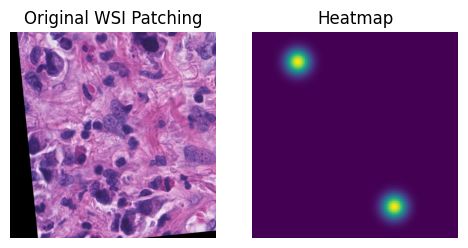

In [73]:
# Convert image to numpy
image = unnormalize_tensor(images[15].clone())
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Plot using subplots
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

# Show the original image
axs[0].imshow(image)
axs[0].set_title("Original WSI Patching")
axs[0].axis('off')

# Show the heatmap
axs[1].imshow(hm[15])  # or use 'viridis', 'jet', etc.
axs[1].set_title("Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()

### 2.2 Check `val_loader` function

In [74]:
for batch in val_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes, _ = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 32 images


In [75]:
images.shape, hm.shape, regr.shape

(torch.Size([32, 3, 512, 512]),
 torch.Size([32, 128, 128]),
 torch.Size([32, 2, 128, 128]))

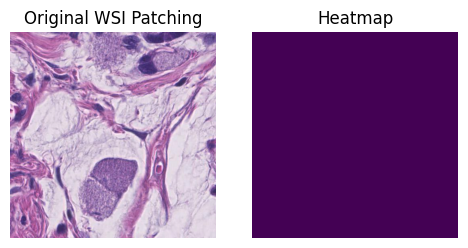

In [76]:
# Convert image to numpy
image = unnormalize_tensor(images[15].clone())
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Plot using subplots
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

# Show the original image
axs[0].imshow(image)
axs[0].set_title("Original WSI Patching")
axs[0].axis('off')

# Show the heatmap
axs[1].imshow(hm[15])  # or use 'viridis', 'jet', etc.
axs[1].set_title("Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()

### 2.3 Check `test_loader` function

In [77]:
for batch in test_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes, _ = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 32 images


In [78]:
images.shape, hm.shape, regr.shape

(torch.Size([32, 3, 512, 512]),
 torch.Size([32, 128, 128]),
 torch.Size([32, 2, 128, 128]))

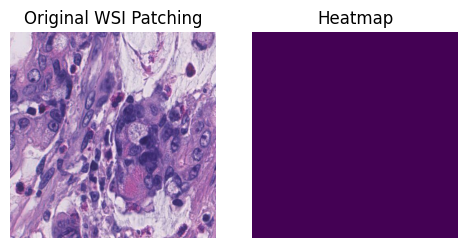

In [79]:
# Convert image to numpy
image = unnormalize_tensor(images[15].clone())
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Plot using subplots
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5))

# Show the original image
axs[0].imshow(image)
axs[0].set_title("Original WSI Patching")
axs[0].axis('off')

# Show the heatmap
axs[1].imshow(hm[15])  # or use 'viridis', 'jet', etc.
axs[1].set_title("Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()